In [1]:
import tensorflow as tf

from distill.common.hparams import TransformerHparam, LSTMHparam
import os

from distill.data_util.prep_algorithmic import AlgorithmicIdentityDecimal40, AlgorithmicIdentityBinary40, \
  AlgorithmicAdditionDecimal40, AlgorithmicMultiplicationDecimal40, AlgorithmicSortProblem, AlgorithmicReverseProblem
from distill.data_util.prep_arithmatic import Arithmatic, ArithmaticSameLength, ArithmaticSimple, ArithmaticSimpleCurriculumLength,\
ArithmaticSimpleSameLength10, ArithmaticSimpleSameLength10Depth6, ArithmaticSimpleSameLength10Depth2, \
  ArithmaticSimpleSameLength10Depth4, \
  ArithmaticSimpleSameLength21Depth2Normal, ArithmaticSimpleSameLength201Depth2Normal, ArithmaticSimpleSameLength21Depth2NormalBiLing
from distill.data_util.prep_imdb import IMDB
from distill.data_util.prep_ptb import PTB
from distill.data_util.prep_sst import SST
from distill.data_util.prep_trec6 import CharTrec6, Trec6
from distill.data_util.prep_wsj_parsing import ParseWSJ
from distill.models.lm_lstm import LmLSTM
from distill.models.lstm_seq2seq import LSTMSeq2Seq, BidiLSTMSeq2Seq
from distill.models.transformer import Transformer, UniversalTransformer, EncodingTransformer, \
  EncodingUniversalTransformer, DecodingUniversalTransformer, DecodingTransformer
from distill.pipelines.distill_pipelines import Seq2SeqParallel
from distill.pipelines.seq2seq import Seq2SeqTrainer

from distill.common.distill_util import *

from sklearn.decomposition import PCA
import pandas as pd
from sklearn import manifold
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  

def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        Include a label next to each point.
    """
    for word in words:
        x, y = M_reduced[word2Ind[word]]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x+.01, y+.01, word, fontsize=10)
    plt.show()

def plot_embedding_components(emb_w):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(emb_w.numpy())
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    tsne_emb = tsne.fit_transform(emb_w.numpy())

    M_reduced_plot_test = principalComponents
    word2Ind_plot_test = student_model.task.word2id
    words = student_model.task.id2word
    plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

    M_reduced_plot_test = tsne_emb
    word2Ind_plot_test = student_model.task.word2id
    words = student_model.task.id2word
    plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)
    

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

In [2]:
tf.app.flags.DEFINE_string("exp_name", "distill", "")
tf.app.flags.DEFINE_string("task_name", "identity_binary", "")
tf.app.flags.DEFINE_string("log_dir", "logs", "")
tf.app.flags.DEFINE_string("data_dir", "../data", "")

tf.app.flags.DEFINE_string("save_dir", None, "")

tf.app.flags.DEFINE_string("model_type", "lstm2transformer", "")
tf.app.flags.DEFINE_string("teacher_model", "lstm", "")
tf.app.flags.DEFINE_string("student_model", "lstm", "")

tf.app.flags.DEFINE_boolean("train_teacher", True, "")
tf.app.flags.DEFINE_boolean("train_student", True, "")
tf.app.flags.DEFINE_boolean("distill_rep", False, "")
tf.app.flags.DEFINE_boolean("distill_logit", True, "")

tf.app.flags.DEFINE_boolean("pretrain_teacher", True, "")
tf.app.flags.DEFINE_integer("teacher_pretraining_iters", 100, "")
tf.app.flags.DEFINE_string("rep_loss_mode", 'dot_product', "representation loss type (squared,softmax_cross_ent,sigmoid_cross_ent")

tf.app.flags.DEFINE_string("model", "enc_utransformer", "transformer | utransformer | lstm | bilstm")
tf.app.flags.DEFINE_string("teacher_encoder_attention_dir", "top_down", "top_down | bottom_up")
tf.app.flags.DEFINE_string("student_encoder_attention_dir", "top_down", "top_down | bottom_up")


tf.app.flags.DEFINE_integer("teacher_hidden_dim", 128, "")
tf.app.flags.DEFINE_integer("teacher_encoder_depth", 1, "")
tf.app.flags.DEFINE_integer("teacher_decoder_depth", 1, "")
tf.app.flags.DEFINE_integer("student_hidden_dim", 128, "")
tf.app.flags.DEFINE_integer("student_encoder_depth", 1, "")
tf.app.flags.DEFINE_integer("student_decoder_depth", 1, "")

tf.app.flags.DEFINE_integer("input_dim", None, "")
tf.app.flags.DEFINE_integer("output_dim", 1, "")
tf.app.flags.DEFINE_integer("number_of_heads", 4, "")
tf.app.flags.DEFINE_integer("ff_filter_size", 512, "")
tf.app.flags.DEFINE_float("initializer_gain", 1.0, "")
tf.app.flags.DEFINE_float("teacher_label_smoothing", 0.0001, "")
tf.app.flags.DEFINE_float("student_label_smoothing", 0.0001, "")

tf.app.flags.DEFINE_boolean('teacher_train_embeddings', True, " False | True")
tf.app.flags.DEFINE_boolean('student_train_embeddings', True, " False | True")

tf.app.flags.DEFINE_string('teacher_sent_rep_mode', "all", "none | final | all")
tf.app.flags.DEFINE_string('student_sent_rep_mode', "all", "none | final | all")

tf.app.flags.DEFINE_string('teacher_attention_mechanism', None, 'attention_mechanism')
tf.app.flags.DEFINE_string('student_attention_mechanism', None, 'attention_mechanism')


tf.app.flags.DEFINE_float("teacher_input_dropout_keep_prob", 0.8, "")
tf.app.flags.DEFINE_float("teacher_hidden_dropout_keep_prob", 0.9, "")
tf.app.flags.DEFINE_float("student_input_dropout_keep_prob", 0.75, "")
tf.app.flags.DEFINE_float("student_hidden_dropout_keep_prob", 0.5, "")


tf.app.flags.DEFINE_float("teacher_learning_rate", 0.001, "")
tf.app.flags.DEFINE_float("student_learning_rate", 0.001, "")
tf.app.flags.DEFINE_float("distill_learning_rate", 0.001, "")
tf.app.flags.DEFINE_float("data_weight", 0.00, "")
tf.app.flags.DEFINE_float("distill_logits_weight", 1.00, "")
tf.app.flags.DEFINE_float("distill_rep_weight", 0.0, "")
tf.app.flags.DEFINE_float("teacher_rep_distill_weight", 0.0, "")
tf.app.flags.DEFINE_float("distill_temp", 1, "")
tf.app.flags.DEFINE_float("teacher_temp", 1, "")
tf.app.flags.DEFINE_float("student_temp", 1, "")
tf.app.flags.DEFINE_boolean("learn_to_teach", False, "")



tf.app.flags.DEFINE_boolean("decay_learning_rate", True, "True | False")
tf.app.flags.DEFINE_float("l2_rate", 0.0001, "")


tf.app.flags.DEFINE_integer("batch_size", 32, "")
tf.app.flags.DEFINE_integer("training_iterations", 300000, "")

tf.app.flags.DEFINE_integer("vocab_size", 3, "")
tf.app.flags.DEFINE_integer("embedding_dim", 128, "embeddings dim")

tf.app.flags.DEFINE_string("data_path", "../data", "data path")



tf.app.flags.DEFINE_string("f","","kernel")
hparams = tf.app.flags.FLAGS

In [3]:
Models = {"lstm": LSTMSeq2Seq,
        "bilstm": BidiLSTMSeq2Seq,
        "transformer": Transformer,
        "utransformer": UniversalTransformer,
        "enc_transformer": EncodingTransformer,
        "enc_utransformer": EncodingUniversalTransformer}


tasks = {'identity': AlgorithmicIdentityDecimal40(os.path.join(hparams.data_dir,'alg')),
       'identity_binary': AlgorithmicIdentityBinary40(os.path.join(hparams.data_dir,'alg')),
       'addition': AlgorithmicAdditionDecimal40(os.path.join(hparams.data_dir,'alg')),
       'multiplication': AlgorithmicMultiplicationDecimal40(os.path.join(hparams.data_dir,'alg')),
       'sort': AlgorithmicSortProblem(os.path.join(hparams.data_dir,'alg')),
       'reverse': AlgorithmicReverseProblem(os.path.join(hparams.data_dir,'alg')),
       'arithmatic': Arithmatic(os.path.join(hparams.data_dir,'arithmatic')),
       'arithmatic_simple': ArithmaticSimple(os.path.join(hparams.data_dir,'arithmatic_simple')),
       'arithmatic_samelength': ArithmaticSameLength(os.path.join(hparams.data_dir,'arithmatic_samelength')),
       'arithmatic_simple_curriculum_length': ArithmaticSimpleCurriculumLength(os.path.join(hparams.data_dir,'arithmatic_simple_curriculum_length')),
       'arithmatic_simple_samelength': ArithmaticSameLength(os.path.join(hparams.data_dir,'arithmatic_samelength')),
       'arithmatic_simple_samelength10': ArithmaticSimpleSameLength10(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10')),
       'arithmatic_simple_samelength10_depth6': ArithmaticSimpleSameLength10Depth6(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10_depth6')),
       'arithmatic_simple_samelength10_depth4': ArithmaticSimpleSameLength10Depth4(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10_depth4')),
       'arithmatic_simple_samelength10_depth2': ArithmaticSimpleSameLength10Depth2(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10_depth2')),
       'arithmatic_simple_samelength21_depth2_normal': ArithmaticSimpleSameLength21Depth2Normal(os.path.join(hparams.data_dir,'arithmatic_simple_samelength21_depth2_normal')),
       'arithmatic_simple_samelength21_depth2_normal_biling': ArithmaticSimpleSameLength21Depth2NormalBiLing(
         os.path.join(hparams.data_dir, 'arithmatic_simple_samelength21_depth2_normal_biling')),
       'arithmatic_simple_samelength201_depth2_normal': ArithmaticSimpleSameLength201Depth2Normal(
         os.path.join(hparams.data_dir, 'arithmatic_simple_samelength201_depth2_normal')),
       'sst': SST(data_path=os.path.join(hparams.data_dir,"sst/"),
             add_subtrees=False,
             pretrained=False),
       'ptb_lm': PTB(os.path.join(hparams.data_dir,'ptb')),
       'wsj_parse': ParseWSJ(os.path.join(hparams.data_dir,'wsj')),
       'imdb': IMDB(data_path=os.path.join(hparams.data_dir,"imdb"),
                    pretrained=True),
        'char_trec': CharTrec6(os.path.join(hparams.data_dir,"char_trec6"), build_vocab=False)
       }

4 total unique words
loading vocab from:  ../data/sst/vocab


In [4]:
hparams.task_name = 'arithmatic_simple_samelength21_depth2_normal_biling'
hparams.vocab_size = tasks[hparams.task_name].vocab_length
hparams.output_dim = len(tasks[hparams.task_name].target_vocab)
task = tasks[hparams.task_name]

Models = {"lstm": LSTMSeq2Seq,
            "bilstm": BidiLSTMSeq2Seq,
            "transformer": Transformer,
            "utransformer": UniversalTransformer,
            "enc_transformer": EncodingTransformer,
            "enc_utransformer": EncodingUniversalTransformer}

CLS_TOKEN = {"lstm": False,
          "bilstm": False,
          "transformer": False,
          "utransformer": False,
          "enc_transformer": True,
          "enc_utransformer": True}

hparams.vocab_size = tasks[hparams.task_name].vocab_length
hparams.output_dim = len(tasks[hparams.task_name].target_vocab)

print(hparams.vocab_size, hparams.output_dim)

PARAM_TYPES = {"lstm": LSTMHparam,
        "bilstm": LSTMHparam,
        "transformer": TransformerHparam,
        "utransformer": TransformerHparam,
        "enc_transformer": TransformerHparam,
        "enc_utransformer": TransformerHparam}

teacher_params = PARAM_TYPES[hparams.teacher_model](input_dim=hparams.input_dim,
                                                  output_dim=hparams.output_dim,
                                                  hidden_dim=hparams.teacher_hidden_dim,
                                                  encoder_depth=hparams.teacher_encoder_depth,
                                                  decoder_depth=hparams.teacher_decoder_depth,
                                                  number_of_heads=4,
                                                  ff_filter_size=hparams.teacher_hidden_dim*4,
                                                  initializer_gain=hparams.initializer_gain,
                                                  batch_size=hparams.batch_size,
                                                  input_dropout_keep_prob=hparams.teacher_input_dropout_keep_prob,
                                                  hidden_dropout_keep_prob=hparams.teacher_hidden_dropout_keep_prob,
                                                  vocab_size=hparams.vocab_size,
                                                  label_smoothing=hparams.teacher_label_smoothing,
                                                  encoder_self_attention_dir=hparams.teacher_encoder_attention_dir,
                                                  decoder_self_attention_dir="top_down",
                                                  decoder_cross_attention_dir="top_down",
                                                  train_embeddings=hparams.teacher_train_embeddings,
                                                  attention_mechanism=None,
                                                  sent_rep_mode=hparams.teacher_sent_rep_mode,
                                                  embedding_dim=hparams.teacher_hidden_dim,
                                                  learning_rate=hparams.teacher_learning_rate,
                                                  cls_token=CLS_TOKEN[hparams.teacher_model]
                                                  )

student_params = PARAM_TYPES[hparams.student_model](input_dim=hparams.input_dim,
                                                  output_dim=hparams.output_dim,
                                                  hidden_dim=hparams.student_hidden_dim,
                                                  encoder_depth=hparams.student_encoder_depth,
                                                  decoder_depth=hparams.student_decoder_depth,
                                                  number_of_heads=4,
                                                  ff_filter_size=hparams.student_hidden_dim*4,
                                                  initializer_gain=hparams.initializer_gain,
                                                  batch_size=hparams.batch_size,
                                                  input_dropout_keep_prob=hparams.student_input_dropout_keep_prob,
                                                  hidden_dropout_keep_prob=hparams.student_hidden_dropout_keep_prob,
                                                  vocab_size=hparams.vocab_size,
                                                  label_smoothing=hparams.student_label_smoothing,
                                                  encoder_self_attention_dir=hparams.student_encoder_attention_dir,
                                                  decoder_self_attention_dir="top_down",
                                                  decoder_cross_attention_dir="top_down",
                                                  train_embeddings=hparams.student_train_embeddings,
                                                  attention_mechanism=None,
                                                  sent_rep_mode=hparams.student_sent_rep_mode,
                                                  embedding_dim=hparams.student_hidden_dim,
                                                  learning_rate=hparams.student_learning_rate,
                                                  cls_token=CLS_TOKEN[hparams.student_model]
                                                  )

51 51


In [5]:
print(hparams.student_model)
student_model = Models[hparams.student_model](student_params,
                                task=tasks[hparams.task_name],
                                scope=hparams.student_model+"_student")

lstm


In [6]:
print(hparams.teacher_model)
teacher_model = Models[hparams.teacher_model](teacher_params,
                                task=tasks[hparams.task_name],
                                scope=hparams.teacher_model+"_teacher")

lstm


In [7]:
dataset = tf.data.TFRecordDataset(student_model.task.get_tfrecord_path(mode="train"))
dataset = dataset.map(student_model.task.parse_examples)
dataset = dataset.padded_batch(hparams.batch_size, padded_shapes=student_model.task.get_padded_shapes())
dataset = dataset.map((lambda x1,x2,x3,x4: ((x1,x2,x3,x4),(x1,x2,x3,x4))))
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.repeat()
train_iterator = dataset.make_one_shot_iterator()

dataset = tf.data.TFRecordDataset(student_model.task.get_tfrecord_path(mode="dev"))
dataset = dataset.map(student_model.task.parse_examples)
dataset = dataset.padded_batch(hparams.batch_size, padded_shapes=student_model.task.get_padded_shapes())
dataset = dataset.map((lambda x1,x2,x3,x4: ((x1,x2,x3,x4),(x1,x2,x3,x4))))
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.repeat()
dev_iterator = dataset.make_one_shot_iterator()

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
teacher_train_examples, student_train_examples = train_iterator.get_next()
teacher_dev_examples, student_dev_examples = dev_iterator.get_next()

student_model.create_vars(reuse=False)



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [9]:
save_dir = "../logs/arithmatic_simple_samelength21_depth2_normal_biling/" + \
"dot_product_lstm_to_lstm_std_depth1_teacher_depth1_std_hidden_dim128_teacher_hidden_dim128__parrallel_tdrop9-9_sdrop9-9_LR001_L20001"
#"dot_product_enc_utransformer_to_enc_utransformer_std_depth4_teacher_depth4_std_hidden_dim256_teacher_hidden_dim256__parallel_tdrop1-1_sdrop1-1_LR001_L20001"
#'dot_product_lstm_to_lstm_std_depth1_teacher_depth1_std_hidden_dim128_teacher_hidden_dim128__indp_drop075-08_drop075-08_L2_v5'

checkpoint = tf.train.latest_checkpoint(save_dir)
print(checkpoint)

/home/samira/Codes/SolutionDistillation/logs/arithmatic_simple_samelength21_depth2_normal_biling/dot_product_lstm_to_lstm_std_depth1_teacher_depth1_std_hidden_dim128_teacher_hidden_dim128__parrallel_tdrop9-9_sdrop9-9_LR001_L20001/model.ckpt-600000


In [10]:
with tfe.restore_variables_on_create(checkpoint):
    teacher_model.create_vars(reuse=False)
    train_output_dic = teacher_model.apply(teacher_train_examples, target_length=student_model.task.target_length, is_train=False)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.


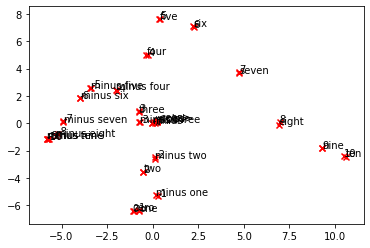

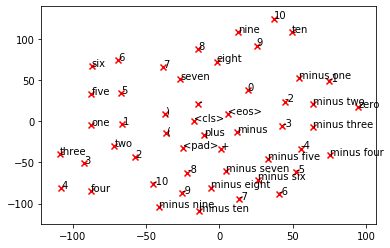

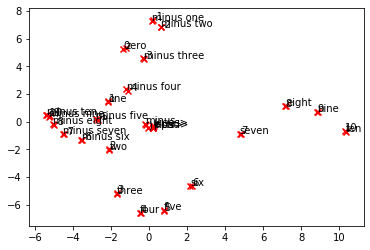

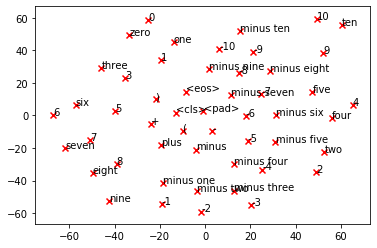

distance with general bias tf.Tensor(0.711766, shape=(), dtype=float32)
distance with local bias tf.Tensor(0.0044744015, shape=(), dtype=float32)
self distance with general bias tf.Tensor(0.0, shape=(), dtype=float32)
self distance with local bias tf.Tensor(0.0, shape=(), dtype=float32)


In [12]:
with tfe.restore_variables_on_create(checkpoint):
    teacher_model.create_vars(reuse=False)
    
teacher_emb_w = teacher_model.input_embedding_layer.shared_weights
plot_embedding_components(teacher_emb_w)


with tfe.restore_variables_on_create(checkpoint):
    student_model.create_vars(reuse=False)
    
student_emb_w = student_model.input_embedding_layer.shared_weights
plot_embedding_components(student_emb_w)

distance_with_general_bias = get_biased_single_state_rsa_distill_loss(student_emb_w, teacher_emb_w, mode='dot_product', bias="general")
distance_with_local_bias = get_biased_single_state_rsa_distill_loss(student_emb_w, teacher_emb_w, mode='dot_product', bias="local")
self_distance_with_general_bias = get_biased_single_state_rsa_distill_loss(teacher_emb_w, teacher_emb_w, mode='dot_product', bias="general")
self_distance_with_local_bias = get_biased_single_state_rsa_distill_loss(teacher_emb_w, teacher_emb_w, mode='dot_product', bias="local")

print("distance with general bias", distance_with_general_bias)
print("distance with local bias", distance_with_local_bias)

print("self distance with general bias", self_distance_with_general_bias)
print("self distance with local bias", self_distance_with_local_bias)

In [31]:
example_str = '0 <eos>' #'1 + 2 - ( 2 + 1 ) + 3  + ( 2 + 1 ) - 3 <eos>'
example_input = example_str.split()
target = str(eval(example_str[0:-5]))
encoded_example = tf.convert_to_tensor([teacher_model.task.encode(example_input)], dtype=tf.int64)
encoded_target = tf.convert_to_tensor([teacher_model.task.encode(target)], dtype=tf.int64)

print(example_input)
example = (encoded_example, encoded_target, tf.convert_to_tensor([len(example_input)], dtype=tf.int64), tf.convert_to_tensor([1], dtype=tf.int64))

weights_dic = {}
with tfe.restore_variables_on_create(checkpoint):
    teach_outputs = train_output_dic = teacher_model.apply(example, \
                                                     target_length=teacher_model.task.target_length, is_train=False)

print(' '.join(student_model.task.decode(example[0][0])))
print(student_model.task.decode([np.argmax(teach_outputs['logits'][0][0])]))

['0', '<eos>']
0 <eos>
['0']


In [14]:
teacher_train_examples, student_train_examples = train_iterator.get_next()
teacher_dev_examples, student_dev_examples = dev_iterator.get_next()

with tfe.restore_variables_on_create(checkpoint):
    train_output_dic = teacher_model.apply(teacher_train_examples, target_length=teacher_model.task.target_length, is_train=False)

In [15]:
np.argmax(train_output_dic['logits'], axis=-1) == train_output_dic['targets'].numpy()

array([[False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True]])

In [34]:
import num2words
from word2number import w2n


examples_inputs = []
examples_targets = []
target_lens = []
input_lens = []
for i in student_model.task.id2word:
    example_input = [str(i),'<eos>']
    examples_inputs.append(teacher_model.task.encode(example_input))
    print(example_input)
    try:
        target = str(eval(example_input[0]))
    except:
        target = example_input[0]
        
    examples_targets.append(teacher_model.task.encode([target]))
    target_lens.append(1)
    input_lens.append(len(example_input))
    
print(examples_inputs)
print(examples_targets)
encoded_example = tf.convert_to_tensor(np.asarray(examples_inputs), dtype=tf.int64)
encoded_target = tf.convert_to_tensor(examples_targets, dtype=tf.int64)

example = (encoded_example, encoded_target, tf.convert_to_tensor(input_lens), tf.convert_to_tensor(target_lens))

weights_dic = {}
with tfe.restore_variables_on_create(checkpoint):
    teach_outputs = teacher_model.apply(example, target_length=teacher_model.task.target_length, is_train=False)
    student_outputs = student_model.apply(example, target_length=student_model.task.target_length, is_train=False)

['<pad>', '<eos>']
['<eos>', '<eos>']
['<cls>', '<eos>']
['-10', '<eos>']
['-9', '<eos>']
['-8', '<eos>']
['-7', '<eos>']
['-6', '<eos>']
['-5', '<eos>']
['-4', '<eos>']
['-3', '<eos>']
['-2', '<eos>']
['-1', '<eos>']
['0', '<eos>']
['1', '<eos>']
['2', '<eos>']
['3', '<eos>']
['4', '<eos>']
['5', '<eos>']
['6', '<eos>']
['7', '<eos>']
['8', '<eos>']
['9', '<eos>']
['10', '<eos>']
['+', '<eos>']
['-', '<eos>']
['minus ten', '<eos>']
['minus nine', '<eos>']
['minus eight', '<eos>']
['minus seven', '<eos>']
['minus six', '<eos>']
['minus five', '<eos>']
['minus four', '<eos>']
['minus three', '<eos>']
['minus two', '<eos>']
['minus one', '<eos>']
['zero', '<eos>']
['one', '<eos>']
['two', '<eos>']
['three', '<eos>']
['four', '<eos>']
['five', '<eos>']
['six', '<eos>']
['seven', '<eos>']
['eight', '<eos>']
['nine', '<eos>']
['ten', '<eos>']
['plus', '<eos>']
['minus', '<eos>']
['(', '<eos>']
[')', '<eos>']
[[0, 1], [1, 1], [2, 1], [3, 1], [4, 1], [5, 1], [6, 1], [7, 1], [8, 1], [9, 1], [1

In [43]:
list(zip(task.decode(np.argmax(student_outputs['logits'], axis=-1)[:,0]), task.decode(np.asarray(examples_targets)[:,0])))

[('3', '<pad>'),
 ('0', '<eos>'),
 ('minus five', '<cls>'),
 ('-10', '-10'),
 ('minus nine', '-9'),
 ('-8', '-8'),
 ('minus seven', '-7'),
 ('minus six', '-6'),
 ('-5', '-5'),
 ('-4', '-4'),
 ('minus three', '-3'),
 ('minus two', '-2'),
 ('minus one', '-1'),
 ('0', '0'),
 ('one', '1'),
 ('two', '2'),
 ('three', '3'),
 ('four', '4'),
 ('5', '5'),
 ('6', '6'),
 ('7', '7'),
 ('8', '8'),
 ('9', '9'),
 ('10', '10'),
 ('ten', '+'),
 ('minus nine', '-'),
 ('-10', 'minus ten'),
 ('minus nine', 'minus nine'),
 ('-8', 'minus eight'),
 ('minus seven', 'minus seven'),
 ('minus six', 'minus six'),
 ('-5', 'minus five'),
 ('-4', 'minus four'),
 ('minus three', 'minus three'),
 ('minus two', 'minus two'),
 ('minus one', 'minus one'),
 ('0', 'zero'),
 ('one', 'one'),
 ('two', 'two'),
 ('three', 'three'),
 ('four', 'four'),
 ('5', 'five'),
 ('6', 'six'),
 ('7', 'seven'),
 ('8', 'eight'),
 ('9', 'nine'),
 ('10', 'ten'),
 ('ten', 'plus'),
 ('minus nine', 'minus'),
 ('five', '('),
 ('three', ')')]

In [41]:
np.asarray(examples_targets)[:,0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

(51, 1, 128)


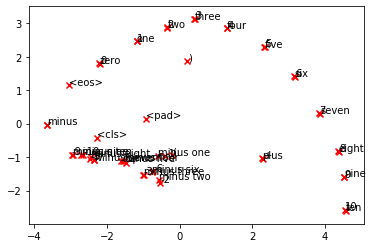

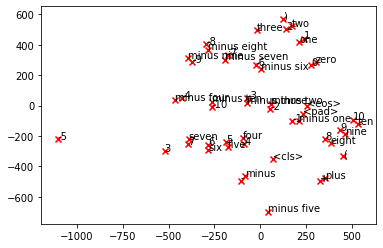

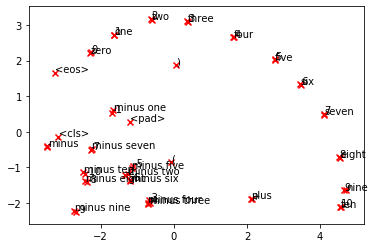

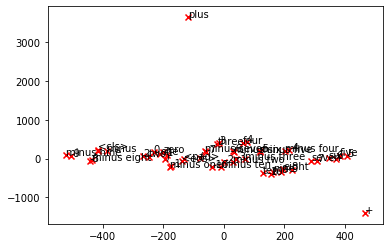

In [20]:
print(teach_outputs['outputs'].numpy().shape)

reps = teach_outputs['outputs'].numpy()[:,0,:]


points = reps
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(points)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=3)
tsne_emb = tsne.fit_transform(points)

M_reduced_plot_test = principalComponents
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

M_reduced_plot_test = tsne_emb
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)



reps = student_outputs['outputs'].numpy()[:,0,:]


points = reps
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(points)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=4)
tsne_emb = tsne.fit_transform(points)

M_reduced_plot_test = principalComponents
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

M_reduced_plot_test = tsne_emb
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)